In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import urllib
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, PoissonRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, f1_score
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
#!pip install catboost

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Collect data from different years in one file 

In [3]:
all_years  = pd.DataFrame()
for i in range(21):
    if len(str(i)) < 2:
        i = f'0{i}'
    new = pd.read_csv(f"atp_matches_doubles_20{i}.csv", index_col=False)
    all_years = pd.concat([all_years,new], ignore_index=True)

In [4]:
all_years.head(5)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner1_id,winner2_id,winner_seed,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2000-301,Auckland,Hard,32.0,A,20000110,300,101704,101097,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-301,Auckland,Hard,32.0,A,20000110,299,101704,101097,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-301,Auckland,Hard,32.0,A,20000110,298,101358,101543,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-301,Auckland,Hard,32.0,A,20000110,297,101704,101097,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-301,Auckland,Hard,32.0,A,20000110,296,101358,101543,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
all_years.describe()

,draw_size,tourney_date,match_num,winner1_id,winner2_id,winner_seed,loser1_id,loser2_id,loser_seed,best_of,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
count,26339.000000,2.639900e+04,26399.000000,26399.000000,26399.000000,11612.000000,26399.000000,26393.000000,6499.000000,26399.000000,...,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000
mean,58.637913,2.009623e+07,325.638168,103813.819084,103910.509868,3.851619,104488.577749,104580.518092,4.321434,3.037653,...,4.131752,3.081597,2.797068,63.890239,41.590664,28.938465,10.962191,9.485532,3.781443,6.309221
std,38.384025,5.895869e+04,374.654210,3530.362666,4023.566404,3.247563,12736.877468,13571.071084,3.391721,0.271829,...,2.946334,2.648939,2.034172,21.959887,15.311817,11.961813,5.180787,3.692370,2.653847,3.156455
min,4.000000,2.000010e+07,3.000000,100431.000000,100581.000000,1.000000,100431.000000,100581.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,2.004101e+07,268.000000,102567.000000,102795.000000,2.000000,102881.000000,102836.000000,2.000000,3.000000,...,2.000000,1.000000,1.000000,53.000000,33.000000,22.000000,8.000000,9.000000,2.000000,4.000000
50%,32.000000,2.010012e+07,288.000000,103566.000000,103580.000000,3.000000,103711.000000,103735.000000,3.000000,3.000000,...,4.000000,2.000000,2.000000,61.000000,40.000000,28.000000,10.000000,10.000000,3.000000,6.000000
75%,64.000000,2.015022e+07,295.000000,104415.000000,104486.000000,4.000000,104600.000000,104583.000000,5.000000,3.000000,...,6.000000,4.000000,4.000000,71.000000,48.000000,34.000000,14.000000,11.000000,5.000000,8.000000
max,128.000000,2.020031e+07,3601.000000,202178.000000,209866.000000,17.000000,900026.000000,900027.000000,17.000000,5.000000,...,18.000000,23.000000,18.000000,268.000000,171.000000,131.000000,56.000000,44.000000,20.000000,22.000000


In [6]:
all_years = all_years.drop(['winner_seed', 'loser_seed', 'winner1_rank_points', 'winner2_rank_points', 'loser1_rank_points', 'loser2_rank_points',  'minutes', 'w_ace', 'w_df',
       'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved',
       'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
       'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced'], axis=1)

In [7]:
players = pd.read_csv('atp_players.csv')

In [8]:
new_players = []
for i, line in players.iterrows():
    if line.player_id in all_years.winner1_id.values or line.player_id in all_years.winner2_id.values or line.player_id in all_years.loser1_id.values or line.player_id in all_years.loser2_id.values:
        new_players.append(i)
print(len(new_players))

1802


In [9]:
players = players.loc[new_players]

In [10]:
players = players.reset_index().drop(['index'], axis=1)

In [11]:
pl_set = dict()
for i, row in all_years.iterrows():
    pl_set[float(row.winner1_id)] = row.winner1_name
    pl_set[float(row.winner2_id)] = row.winner2_name
    pl_set[float(row.loser1_id)] = row.loser1_name
    pl_set[float(row.loser2_id)] = row.loser2_name

In [12]:
full_names = []
for i, p in players.iterrows():
    full_names.append(pl_set[float(p.player_id)])

In [13]:
players['full_names'] = full_names

# Data scrapping

In [13]:
def get_stats_by_name(name, surname):
    stat_dict = {}
    site = f'https://www.ultimatetennisstatistics.com/playerProfile?name={name}+{surname}&tab=statistics'
    headers = {'Accept-Language': 'en', 'X-FORWARDED-FOR': '2.21.184.0'}
    response = requests.get(site, headers=headers)
    assert response.status_code == 200
    soup = BeautifulSoup(response.text)
    #print(soup)
    table = soup.find('a', attrs = {'data-toggle':"pill"})
    id = re.findall(r'[0-9]+', str(table))

    site = f'https://www.ultimatetennisstatistics.com/playerStatsTab?playerId={id[0]}'

    response = requests.get(site, headers=headers)
    assert response.status_code == 200
    soup = BeautifulSoup(response.text)
    stats = soup.find_all('tbody')
    try:
        stat_dict['Ace%'] = stats[0].find_all('th', attrs = {'class': "text-right pct-data"})[0].get_text()[:-1]
    except:
        stat_dict['Ace%'] = np.nan
    try:
        stat_dict['DF%'] = stats[0].find_all('th', attrs = {'class': "text-right pct-data"})[1].get_text()[:-1]
    except:
        stat_dict['DF%'] = np.nan
    try:
        stat_dict['BP_saved%'] = stats[0].find_all('th', attrs = {'class': "text-right pct-data"})[5].get_text()[:-1]
    except:
        stat_dict['BP_saved%'] = np.nan
    try:
        stat_dict['Ace_against%'] = stats[1].find_all('th', attrs = {'class': "text-right pct-data"})[0].get_text()[:-1]
    except:
        stat_dict['Ace_against%'] = np.nan
    try:
        stat_dict['BP_won%'] = stats[1].find_all('th', attrs = {'class': "text-right pct-data"})[4].get_text()[:-1]
    except:
        stat_dict['BP_won%'] = np.nan
    try:
        stat_dict['Return_won%'] = stats[1].find_all('th', attrs = {'class': "text-right pct-data"})[5].get_text()[:-1]
    except:
        stat_dict['Return_won%'] = np.nan
    try:
        stat_dict['Points_dominance'] = stats[2].find_all('th', attrs = {'class': "text-right"})[0].get_text()
    except:
        stat_dict['Points_dominance'] = np.nan
    try:
        stat_dict['Serve_rating'] = stats[6].find_all('th', attrs = {'class': "text-right"})[7].get_text()
    except:
        stat_dict['Serve_rating'] = np.nan
    try:
        stat_dict['Game_time'] = stats[26].find_all('th', attrs = {'class': "text-right"})[1].get_text()
    except:
        stat_dict['Game_time'] = np.nan
    return stat_dict

In [12]:
players

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id
0,100431,Mansour,Bahrami,R,19560426.0,IRI,178.0,Q564631
1,100581,John,McEnroe,L,19590216.0,USA,180.0,Q16474
2,100644,Alexander,Zverev,R,19970420.0,GER,198.0,Q13990552
3,100757,Anders,Jarryd,R,19610713.0,SWE,180.0,Q455136
4,100819,Daniel,Montes De Oca,R,19620426.0,URU,170.0,Q107986458
...,...,...,...,...,...,...,...,...
1797,209080,Blaise,Bicknell,R,20011126.0,USA,188.0,Q96678039
1798,209238,Sebastian,Dominguez,NaN,20020622.0,GUA,NaN,NaN
1799,209327,Rashed,Nawaf,R,20050601.0,QAT,NaN,Q81217332
1800,209866,Karlis,Ozolins,R,20020615.0,LAT,NaN,Q88330726


In [ ]:
stat_dict = {'Ace%': [],
     'DF%': [],
     'BP_saved%': [],
     'Ace_against%': [],
     'BP_won%': [],
     'Return_won%': [],
     'Points_dominance': [],
     'Serve_rating': [],
     'Game_time': []}
for i, line in players.iterrows():
    cur_d = get_stats_by_name(line.name_first, line.name_last)
    stat_dict['Ace%'].append(float(cur_d['Ace%']))
    stat_dict['DF%'].append(float(cur_d['DF%']))
    stat_dict['BP_saved%'].append(float(cur_d['BP_saved%']))
    stat_dict['Ace_against%'].append(float(cur_d['Ace_against%']))
    stat_dict['BP_won%'].append(float(cur_d['BP_won%']))
    stat_dict['Return_won%'].append(float(cur_d['Return_won%']))
    stat_dict['Points_dominance'].append(float(cur_d['Points_dominance']))
    stat_dict['Serve_rating'].append(float(cur_d['Serve_rating']))
    stat_dict['Game_time'].append(float(cur_d['Game_time']))


    if np.nan in list(cur_d.values()):
        print(line.name_first, line.name_last)

    if i % 10== 0:
        print(i)


In [184]:
#stats.to_csv('stats.csv', index=False) 

# Merge players' stats 

In [14]:
stats = pd.read_csv('stats.csv')

In [15]:
all_stats = pd.concat([players, stats], axis=1, join="inner")

In [16]:
all_stats.head(5)

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id,full_names,Ace%,DF%,BP_saved%,Ace_against%,BP_won%,Return_won%,Points_dominance,Serve_rating,Game_time
0,100431,Mansour,Bahrami,R,19560426.0,IRI,178.0,Q564631,Mansour Bahrami,5.3,2.6,55.0,5.2,41.7,35.1,0.81,289.0,3.62
1,100581,John,McEnroe,L,19590216.0,USA,180.0,Q16474,John Mcenroe,6.8,5.1,62.4,6.5,41.8,39.4,1.11,328.0,4.63
2,100644,Alexander,Zverev,R,19970420.0,GER,198.0,Q13990552,Alexander Zverev,10.6,5.1,60.6,5.6,41.6,38.3,1.12,338.0,4.21
3,100757,Anders,Jarryd,R,19610713.0,SWE,180.0,Q455136,Anders Jarryd,4.9,5.1,56.0,5.3,42.2,39.2,1.03,307.0,3.96
4,100819,Daniel,Montes De Oca,R,19620426.0,URU,170.0,Q107986458,Daniel Montes De Oca,35.6,9.1,NaN,35.6,NaN,NaN,1.00,NaN,NaN


Inspect what different partners did players have

In [17]:
all_stats.to_csv('all_stats.csv')

In [18]:
pairs = []
antipairs = []
for i, r in all_years.iterrows():
    pairs.append((r.winner1_name, r.winner2_name))
    pairs.append((r.loser1_name, r.loser2_name))
    antipairs.append((r.winner2_name, r.winner1_name))
    antipairs.append((r.loser2_name, r.loser1_name))

In [19]:
for i, j in zip(set(pairs), set(antipairs)):
    if i == j:
        print(i, j)


('Michael Kohlmann', 'Tomas Behrend') ('Michael Kohlmann', 'Tomas Behrend')
('Nicolas Almagro', 'David Ferrer') ('Nicolas Almagro', 'David Ferrer')
('Paul Capdeville', 'Juan Ignacio Cerda') ('Paul Capdeville', 'Juan Ignacio Cerda')


Above there are pairs that are not always in the order, I will deal with it in the next section

In [20]:
player_to_partners = dict()
for ind, i in players.iterrows():
    name = i.full_names
    player_to_partners[name] = []
    for j in set(pairs):
        if j[0] == name:
            player_to_partners[name].append(j[1])
        elif j[1] == name:
            player_to_partners[name].append(j[0])

In [21]:
{k: len(v) for k, v in sorted(player_to_partners.items(), key=lambda item: len(item[1]), reverse=True) if len(v) > 10}

{'Nenad Zimonjic': 99,
 'Robert Lindstedt': 91,
 'Andre Sa': 81,
 'Jurgen Melzer': 81,
 'Mikhail Youzhny': 77,
 'Chris Haggard': 76,
 'Andreas Seppi': 75,
 'Dominik Hrbaty': 74,
 'Jonathan Erlich': 72,
 'James Cerretani': 72,
 'Fabio Fognini': 72,
 'Michael Kohlmann': 71,
 'Julian Knowle': 71,
 'Rogier Wassen': 69,
 'Guillermo Garcia Lopez': 69,
 'Oliver Marach': 67,
 'Dmitry Tursunov': 67,
 'Leander Paes': 66,
 'Aisam Ul Haq Qureshi': 66,
 'Jarkko Nieminen': 66,
 'Carlos Berlocq': 66,
 'Albert Ramos': 65,
 'Feliciano Lopez': 64,
 'Robin Haase': 64,
 'Jim Thomas': 63,
 'Benoit Paire': 62,
 'Mahesh Bhupathi': 61,
 'Rainer Schuettler': 61,
 'Tommy Robredo': 61,
 'Lukas Rosol': 61,
 'Mischa Zverev': 61,
 'Max Mirnyi': 60,
 'Rohan Bopanna': 60,
 'Benjamin Becker': 60,
 'Rajeev Ram': 60,
 'Paul Hanley': 59,
 'Lucas Arnold Ker': 58,
 'Fernando Verdasco': 58,
 'Teymuraz Gabashvili': 58,
 'Viktor Troicki': 58,
 'Jeremy Chardy': 58,
 'Frank Moser': 57,
 'Gilles Simon': 55,
 'David Marrero': 54,

Graphs

In [22]:
graph1 = all_stats[['Ace%', 'DF%']].dropna() 

In [23]:
graph1.to_csv('graph1.csv')

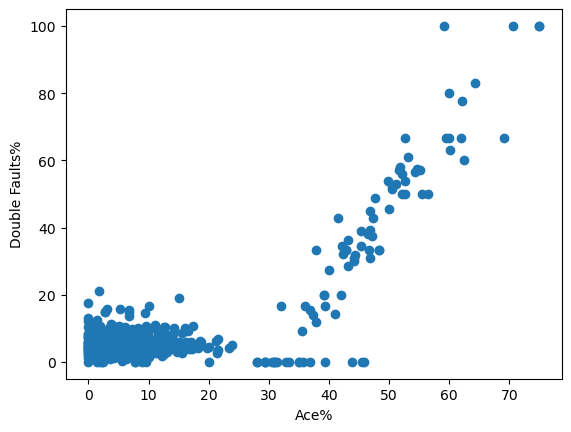

In [24]:
plt.scatter(graph1['Ace%'], graph1['DF%'])
plt.xlabel("Ace%")
plt.ylabel("Double Faults%")
plt.show()

In [26]:
graph2 = all_stats[['Ace%', 'Ace_against%', 'height']].dropna() 

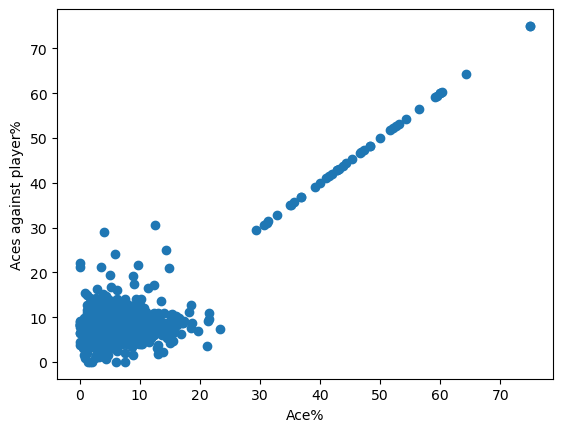

In [27]:
plt.scatter(graph2['Ace%'], graph2['Ace_against%'])
plt.xlabel("Ace%")
plt.ylabel("Aces against player%")
plt.show()

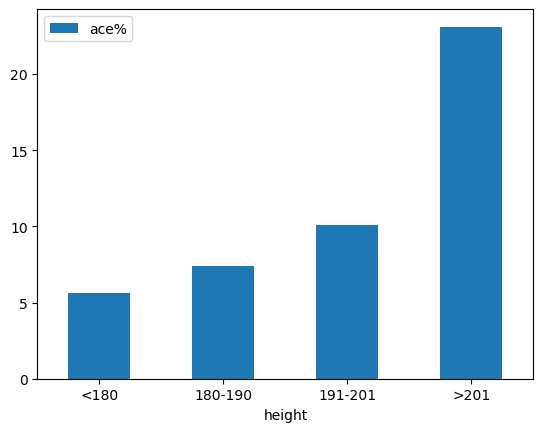

In [28]:
bar_graph = pd.DataFrame({'height':['<180', '180-190', '191-201', '>201'], 'ace%':[graph2[graph2.height <= 179]['Ace%'].mean(), graph2[(graph2.height > 179)&(graph2.height <= 190)]['Ace%'].mean(), graph2[(graph2.height>190)&(graph2.height <= 201)]['Ace%'].mean(), graph2[graph2.height >201]['Ace%'].mean()]})
ax = bar_graph.plot.bar(x='height', y='ace%', rot=0)

In [31]:
all_stats.describe()

,player_id,dob,height,Ace%,DF%,BP_saved%,Ace_against%,BP_won%,Return_won%,Points_dominance,Serve_rating,Game_time
count,1802.000000,1.787000e+03,1233.000000,1370.000000,1370.000000,1281.000000,1370.00000,1281.000000,1281.000000,1370.000000,1281.000000,1281.000000
mean,111498.481132,1.984103e+07,184.776156,8.572263,6.398540,56.535597,10.20708,37.455504,34.155269,1.127869,302.139735,4.096089
std,22173.743135,8.447726e+04,6.435256,10.639005,10.380157,9.981891,10.21636,12.936789,6.827748,6.661251,33.783432,0.520085
min,100431.000000,1.956043e+07,168.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,122.000000,0.000000
25%,103154.750000,1.978011e+07,180.000000,3.800000,3.200000,54.500000,5.70000,33.700000,32.700000,0.800000,291.000000,3.840000
50%,104504.500000,1.984042e+07,185.000000,5.900000,4.200000,58.500000,7.60000,38.200000,35.500000,0.900000,308.000000,4.110000
75%,106074.250000,1.991022e+07,188.000000,8.600000,5.500000,61.500000,9.87500,41.100000,37.500000,0.970000,322.000000,4.380000
max,209868.000000,2.005060e+07,211.000000,75.000000,100.000000,91.700000,75.00000,100.000000,56.700000,245.000000,390.000000,8.510000


### Here I try to find pairs which are not always in correct order, so later I can put them in a desired order

('Bobby Reynolds', 'Rajeev Ram') ('Bobby Reynolds', 'Rajeev Ram')
('Julian Knowle', 'Christopher Kas') ('Julian Knowle', 'Christopher Kas')
('Fernando Verdasco', 'Fernando Vicente') ('Fernando Verdasco', 'Fernando Vicente')
('Juho Paukku', 'Filip Prpic') ('Juho Paukku', 'Filip Prpic')
('Marko Djokovic', 'Novak Djokovic') ('Marko Djokovic', 'Novak Djokovic')
('Mark Woodforde', 'Todd Woodbridge') ('Mark Woodforde', 'Todd Woodbridge')

For the first, second and fifth pairs problem appears only when they are losers

In [32]:
all_years[((all_years.loser1_name=='Bobby Reynolds') &  (all_years.loser2_name=='Rajeev Ram')) | ((all_years.loser2_name=='Bobby Reynolds') & (all_years.loser1_name=='Rajeev Ram'))].head(4)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner1_id,winner2_id,winner_entry,...,loser1_age,loser2_name,loser2_hand,loser2_ht,loser2_ioc,loser2_age,winner1_rank,winner2_rank,loser1_rank,loser2_rank
4653,2003-419,Indianapolis,Hard,48.0,A,20030721,292,103459,102501,NaN,...,19.340178,Bobby Reynolds,R,183.0,USA,21.010267,56.0,69.0,491.0,567.0
6945,2005-3348,New Haven,Hard,48.0,A,20050822,300,102477,101675,NaN,...,21.429158,Bobby Reynolds,R,183.0,USA,23.099247,35.0,28.0,131.0,170.0
7368,2005-433,Scottsdale,Hard,32.0,A,20050221,287,104229,103039,NaN,...,20.930869,Bobby Reynolds,R,183.0,USA,22.600958,89.0,87.0,147.0,267.0
10863,2008-402,Memphis,Hard,32.0,A,20080225,286,105023,102434,NaN,...,25.609856,Rajeev Ram,R,193.0,USA,23.939767,132.0,270.0,77.0,51.0


In [33]:
all_years[((all_years.loser1_name=='Julian Knowle') &  (all_years.loser2_name=='Christopher Kas')) | ((all_years.loser2_name=='Julian Knowle') & (all_years.loser1_name=='Christopher Kas'))]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner1_id,winner2_id,winner_entry,...,loser1_age,loser2_name,loser2_hand,loser2_ht,loser2_ioc,loser2_age,winner1_rank,winner2_rank,loser1_rank,loser2_rank
15950,2012-360,Casablanca,Clay,28.0,A,20120409,291,104249,103543,NaN,...,31.822040,Julian Knowle,L,188.0,AUT,37.946612,36.0,26.0,19.0,61.0
18518,2014-360,Casablanca,Clay,28.0,A,20140407,289,103876,104160,NaN,...,39.939767,Christopher Kas,R,188.0,GER,33.815195,45.0,52.0,38.0,55.0


In [34]:
all_years[((all_years.loser1_name=='Marko Djokovic') &  (all_years.loser2_name=='Novak Djokovic')) | ((all_years.loser2_name=='Marko Djokovic') & (all_years.loser1_name=='Novak Djokovic'))].head(2)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner1_id,winner2_id,winner_entry,...,loser1_age,loser2_name,loser2_hand,loser2_ht,loser2_ioc,loser2_age,winner1_rank,winner2_rank,loser1_rank,loser2_rank
9944,2007-439,Umag,Clay,32.0,A,20070723,286,104515,104273,NaN,...,15.923340,Novak Djokovic,R,188.0,SRB,20.169747,399.0,227.0,NaN,269.0
10561,2008-1720,Bangkok,Hard,28.0,A,20080922,287,102148,104542,NaN,...,21.338809,Marko Djokovic,R,NaN,SRB,17.092402,87.0,80.0,567.0,NaN


For the third, forth and sixth the order is different for win and lose

In [35]:
print(all_years[((all_years.winner1_name=='Fernando Verdasco') &  (all_years.winner2_name=='Fernando Vicente')) | ((all_years.winner2_name=='Fernando Verdasco') & (all_years.winner1_name=='Fernando Vicente'))][['winner1_name', 'winner2_name']])
print(all_years[((all_years.loser1_name=='Fernando Verdasco') &  (all_years.loser2_name=='Fernando Vicente')) | ((all_years.loser2_name=='Fernando Verdasco') & (all_years.loser1_name=='Fernando Vicente'))][['loser1_name', 'loser2_name']])

          winner1_name       winner2_name
6914  Fernando Vicente  Fernando Verdasco
            loser1_name       loser2_name
6906  Fernando Verdasco  Fernando Vicente


In [36]:
print(all_years[((all_years.winner1_name=='Juho Paukku') &  (all_years.winner2_name=='Filip Prpic')) | ((all_years.winner2_name=='Juho Paukku') & (all_years.winner1_name=='Filip Prpic'))][['winner1_name', 'winner2_name']])
print(all_years[((all_years.loser1_name=='Juho Paukku') &  (all_years.loser2_name=='Filip Prpic')) | ((all_years.loser2_name=='Juho Paukku') & (all_years.loser1_name=='Filip Prpic'))][['loser1_name', 'loser2_name']])

     winner1_name winner2_name
9899  Filip Prpic  Juho Paukku
      loser1_name  loser2_name
9890  Juho Paukku  Filip Prpic


In [37]:
print(all_years[((all_years.winner1_name=='Mark Woodforde') &  (all_years.winner2_name=='Todd Woodbridge')) | ((all_years.winner2_name=='Mark Woodforde') & (all_years.winner1_name=='Todd Woodbridge'))][['winner1_name', 'winner2_name']].head(1))
print(all_years[((all_years.loser1_name=='Mark Woodforde') &  (all_years.loser2_name=='Todd Woodbridge')) | ((all_years.loser2_name=='Mark Woodforde') & (all_years.loser1_name=='Todd Woodbridge'))][['loser1_name', 'loser2_name']].head(1))

      winner1_name     winner2_name
45  Mark Woodforde  Todd Woodbridge
         loser1_name     loser2_name
438  Todd Woodbridge  Mark Woodforde


# Merge players' stats with match statistics

In [37]:
matches_by_pairs = pd.DataFrame(columns = ['pair','win','surface','tourney_level', 'entry', 'score_dif', 'round', 'name1', 'name2', 'hand1', 'hand2', 'height1', 'height2', 'age1', 'age2', "ioc1", 'ioc2', 'rank1', 'rank2'])
for i, row in all_years.iterrows():
    flag=False
    point_dif = 0
    try:
        s = row.score.split()
    except:
        s = ['0-0', '0-0']
    l = len(s) * 6
    for j in range(len(s)):
        if '7' in s[j] or s[j] == 'RET' or s[j] == 'W/O' or s[j] == 'DEF' :
            s[j] = '0-0'        
        elif s[j][0] == '(' and s[j][-1] == ')':
            s[j] = s[j][1:-1]
            flag =True
        a, b = s[j].split('-')
        try:
            point_dif += int(a) - int(b)
        except:
            print(row.score)
    if flag:
        score_dif = point_dif/16
    else:
        score_dif = point_dif/(3*(int(row.best_of) + 1))

    if row.loser1_name != row.loser1_name or row.loser2_name != row.loser2_name or row.winner1_name != row.winner1_name or row.winner2_name != row.winner2_name:
        continue

    #Correct pair order
    if row.loser2_name=='Bobby Reynolds' and row.loser1_name=='Rajeev Ram':
        lose = [(row.loser2_name, row.loser1_name), 0,row.surface,row.tourney_level, row.loser_entry, -score_dif, row['round'], row.loser2_name, row.loser1_name, row.loser2_hand, row.loser1_hand, row.loser2_ht, row.loser1_ht, row.loser2_age, row.loser1_age, row.loser2_ioc, row.loser1_ioc ,row.loser2_rank, row.loser1_rank]
        print('case1')
    elif row.loser2_name=='Julian Knowle' and row.loser1_name=='Christopher Kas':
        lose = [(row.loser2_name, row.loser1_name), 0,row.surface,row.tourney_level, row.loser_entry, -score_dif, row['round'], row.loser2_name, row.loser1_name, row.loser2_hand, row.loser1_hand, row.loser2_ht, row.loser1_ht, row.loser2_age, row.loser1_age, row.loser2_ioc, row.loser1_ioc ,row.loser2_rank, row.loser1_rank]
        print('case2')
    elif row.loser2_name=='Fernando Vicente' and row.loser1_name=='Fernando Verdasco':
        lose = [(row.loser2_name, row.loser1_name), 0,row.surface,row.tourney_level, row.loser_entry, -score_dif, row['round'], row.loser2_name, row.loser1_name, row.loser2_hand, row.loser1_hand, row.loser2_ht, row.loser1_ht, row.loser2_age, row.loser1_age, row.loser2_ioc, row.loser1_ioc ,row.loser2_rank, row.loser1_rank]
        print('case3')
    elif row.loser2_name=='Filip Prpic' and row.loser1_name=='Juho Paukku':
        lose = [(row.loser2_name, row.loser1_name), 0,row.surface,row.tourney_level, row.loser_entry, -score_dif, row['round'], row.loser2_name, row.loser1_name, row.loser2_hand, row.loser1_hand, row.loser2_ht, row.loser1_ht, row.loser2_age, row.loser1_age, row.loser2_ioc, row.loser1_ioc ,row.loser2_rank, row.loser1_rank]
        print('case4')
    elif row.loser2_name=='Marko Djokovic' and row.loser1_name=='Novak Djokovic':
        lose = [(row.loser2_name, row.loser1_name), 0,row.surface,row.tourney_level, row.loser_entry, -score_dif, row['round'], row.loser2_name, row.loser1_name, row.loser2_hand, row.loser1_hand, row.loser2_ht, row.loser1_ht, row.loser2_age, row.loser1_age, row.loser2_ioc, row.loser1_ioc ,row.loser2_rank, row.loser1_rank]
        print('case5')
    elif row.loser2_name=='Mark Woodforde' and row.loser1_name=='Todd Woodbridge': 
        lose = [(row.loser2_name, row.loser1_name), 0,row.surface,row.tourney_level, row.loser_entry, -score_dif, row['round'], row.loser2_name, row.loser1_name, row.loser2_hand, row.loser1_hand, row.loser2_ht, row.loser1_ht, row.loser2_age, row.loser1_age, row.loser2_ioc, row.loser1_ioc ,row.loser2_rank, row.loser1_rank]
        print('case6')
    else:
        lose = [(row.loser1_name, row.loser2_name), 0,row.surface,row.tourney_level, row.loser_entry, -score_dif, row['round'], row.loser1_name, row.loser2_name, row.loser1_hand, row.loser2_hand, row.loser1_ht, row.loser2_ht, row.loser1_age, row.loser2_age, row.loser1_ioc, row.loser2_ioc ,row.loser1_rank, row.loser2_rank]
    win = [(row.winner1_name, row.winner2_name), 1, row.surface,row.tourney_level, row.winner_entry, score_dif, row['round'], row.winner1_name, row.winner2_name, row.winner1_hand, row.winner2_hand, row.winner1_ht, row.winner2_ht, row.winner1_age, row.winner1_age, row.winner1_ioc, row.winner2_ioc ,row.winner1_rank, row.winner2_rank] 
    
    matches_by_pairs.loc[-1] = win
    matches_by_pairs.index = matches_by_pairs.index + 1
    matches_by_pairs.loc[-1] = lose# shifting index
    matches_by_pairs.index = matches_by_pairs.index + 1
    matches_by_pairs = matches_by_pairs.sort_index()
    if i % 1000 == 0:
        print(i)



0
case6
case6
case6
case6
1000
case6
case6
case6
case6
2000
3000
4000
case1
5000
6000
case3
case1
7000
case1
8000
9000
case4
10000
case5
11000
case1
case1
case1
12000
case5
13000
14000
case1
15000
case2
16000
17000
case5
18000
19000
20000
21000
22000
23000
24000
25000
26000


Transform variables to numeric. Tourney levels to points earned in ATP, tour of the match to a numeric equivalent

In [38]:
matches_by_pairs['tourney_level'] = matches_by_pairs['tourney_level'].map({'D': 500, 'A':500, 'M': 1000, 'G': 2000, 'F': 2000})

In [39]:
matches_by_pairs['round'] = matches_by_pairs['round'].map({'Q1': 1/64, 'Q2': 1/64, 'R128': 1/64, 'R64': 1/32, 'R32': 1/16, 'RR': 1/16, 'BR': 1/16, 'R16': 1/8, 'QF': 1/4, 'SF': 1/2, 'F': 1})

In [1148]:
#matches_by_pairs.to_csv('matches_by_pairs.csv', index=False) 
matches_by_pairs = pd.read_csv('matches_by_pairs.csv')

In [40]:
matches_by_pairs['success'] = matches_by_pairs['win'] 
#matches_by_pairs['success'] =(matches_by_pairs['round']>=1/8)*matches_by_pairs.win

In [41]:
matches_by_pairs['rank1'] = matches_by_pairs['rank1'].fillna(2500)
matches_by_pairs['rank2'] = matches_by_pairs['rank2'].fillna(2500)

In [1391]:
f = {'success':['mean'], 'rank1':['mean'], 'rank2':['mean'], 'name1':['first'], 'name2':['first'], 'age1':['mean'], 'age2':['mean'], 'round':['count']}

only_results = matches_by_pairs.groupby('pair').agg(f)

In [1392]:
only_results.columns = only_results.columns.droplevel(1)

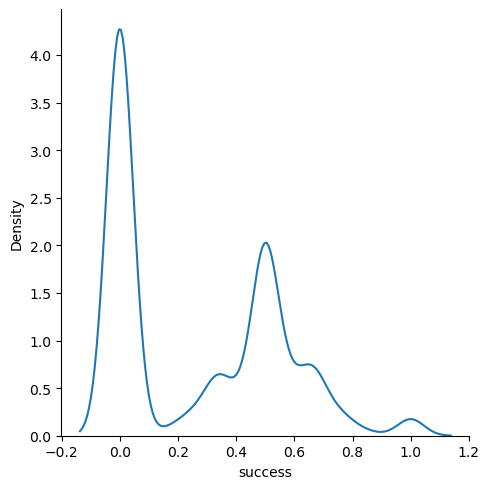

In [1396]:
sns.displot(only_results.success, kind='kde')

Creating merged table

In [1398]:
merged_df = pd.merge(only_results, all_stats, left_on='name1', right_on='full_names')
new_cols=['success', 'rank1', 'rank2', 'name1', 'name2','age1','age2','number','player_id1',
       'name_first1', 'name_last1', 'hand1', 'dob1', 'ioc1', 'height1',
       'wikidata_id1', 'full_names1', 'Ace%1', 'DF%1', 'BP_saved%1', 'Ace_against%1',
       'BP_won%1', 'Return_won%1', 'Points_dominance1', 'Serve_rating1',
       'Game_time1']
merged_df.columns = new_cols

In [1399]:
merged_df = pd.merge(merged_df, all_stats, left_on='name2', right_on='full_names')


In [1400]:
new_cols = ['success', 'rank1', 'rank2', 'name1', 'name2','age1','age2','number','player_id1',
       'name_first1', 'name_last1', 'hand1', 'dob1', 'ioc1', 'height1',
       'wikidata_id1', 'full_names1', 'Ace%1', 'DF%1', 'BP_saved%1',
       'Ace_against%1', 'BP_won%1', 'Return_won%1', 'Points_dominance1',
       'Serve_rating1', 'Game_time1', 'player_id2', 'name_first2', 'name_last2',
       'hand2', 'dob2', 'ioc2', 'height2', 'wikidata_id2', 'full_names2', 'Ace%2',
       'DF%2', 'BP_saved%2', 'Ace_against%2', 'BP_won%2', 'Return_won%2',
       'Points_dominance2', 'Serve_rating2', 'Game_time2']
merged_df.columns = new_cols

In [1401]:
merged_df['relatives'] = (merged_df.name_last1 == merged_df.name_last2)

In [1402]:
merged_df = merged_df.drop(['player_id1',
       'name_first1', 'name_last1', 'wikidata_id1', 'full_names1', 'player_id2',
       'name_first2', 'name_last2', 'wikidata_id2', 'full_names2', 'dob1','dob2'], axis=1)

In [1403]:
merged_df = merged_df.dropna().reset_index().drop(['index'], axis=1)

In [1310]:
merged_df.head(5)

,success,rank1,rank2,name1,name2,age1,age2,number,hand1,ioc1,...,Ace%2,DF%2,BP_saved%2,Ace_against%2,BP_won%2,Return_won%2,Points_dominance2,Serve_rating2,Game_time2,relatives
0,0.000000,537.000000,362.285714,Adrian Mannarino,Benoit Paire,25.505818,24.648871,7,L,FRA,...,10.2,6.3,59.4,4.7,39.8,37.8,0.95,309.0,3.79,False
1,0.333333,44.500000,230.333333,David Marrero,Benoit Paire,36.413872,30.359571,6,R,ESP,...,10.2,6.3,59.4,4.7,39.8,37.8,0.95,309.0,3.79,False
2,0.555556,80.888889,131.833333,Leander Paes,Benoit Paire,45.839988,38.777550,18,R,IND,...,10.2,6.3,59.4,4.7,39.8,37.8,0.95,309.0,3.79,False
3,0.181818,1398.454545,194.727273,Paul Henri Mathieu,Benoit Paire,34.656213,28.668533,11,R,FRA,...,10.2,6.3,59.4,4.7,39.8,37.8,0.95,309.0,3.79,False
4,0.666667,164.666667,142.000000,Thomaz Bellucci,Benoit Paire,25.209217,24.757472,6,L,BRA,...,10.2,6.3,59.4,4.7,39.8,37.8,0.95,309.0,3.79,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,0.411765,856.176471,356.705882,Tommy Haas,Glenn Weiner,23.818658,24.955671,17,R,GER,...,11.3,6.6,53.6,9.1,34.2,34.2,0.92,314.0,3.82,False
1150,0.500000,210.833333,357.833333,Vasilis Mazarakis,Boris Pashanski,26.021903,24.655715,6,R,GRE,...,3.2,4.3,56.6,10.6,39.0,35.5,0.85,298.0,4.44,False
1151,0.500000,29.800000,162.000000,Wayne Arthurs,Ben Ellwood,29.864203,27.371389,10,L,AUS,...,6.1,4.9,53.7,4.9,43.6,37.8,0.90,293.0,3.53,False
1152,0.714286,228.285714,206.142857,Yen Hsun Lu,Danai Udomchoke,28.585900,29.159284,7,R,TPE,...,4.2,4.5,56.4,9.2,36.9,36.0,0.87,299.0,4.04,False


In [38]:
#merged_df.to_csv('data_by_pairs.csv', index=False) 
merged_df = pd.read_csv('data_by_pairs.csv')

In [39]:
one_time = list(merged_df.dropna().reset_index()[merged_df.number<2][['name1', 'name2']].index)

# Data set without nans and making combined variables

In [40]:
merged_df = merged_df.dropna()

In [41]:
merged_df['height1'] = merged_df['height1'].astype('int32')
merged_df['height2'] = merged_df['height2'].astype('int32')

In [42]:
numeric = []
for i in merged_df:
    if (merged_df[i].dtype == 'float64' or merged_df[i].dtype == 'int32') and i != 'dob1' and i!= 'dob2':
        numeric.append(i)
    

In [43]:
clean = merged_df.copy()

In [44]:
clean.columns

Index(['success', 'rank1', 'rank2', 'name1', 'name2', 'age1', 'age2', 'number',
       'hand1', 'ioc1', 'height1', 'Ace%1', 'DF%1', 'BP_saved%1',
       'Ace_against%1', 'BP_won%1', 'Return_won%1', 'Points_dominance1',
       'Serve_rating1', 'Game_time1', 'hand2', 'ioc2', 'height2', 'Ace%2',
       'DF%2', 'BP_saved%2', 'Ace_against%2', 'BP_won%2', 'Return_won%2',
       'Points_dominance2', 'Serve_rating2', 'Game_time2', 'relatives'],
      dtype='object')

In [45]:
clean.head(5)

,success,rank1,rank2,name1,name2,age1,age2,number,hand1,ioc1,...,Ace%2,DF%2,BP_saved%2,Ace_against%2,BP_won%2,Return_won%2,Points_dominance2,Serve_rating2,Game_time2,relatives
3,0.000000,232.0,722.0,Malek Jaziri,Lamine Ouahab,34.217659,33.295003,1,R,TUN,...,2.6,4.1,55.6,6.1,47.1,36.4,0.84,288.0,4.02,False
4,0.000000,2500.0,391.0,Reda El Amrani,Lamine Ouahab,27.876797,31.282683,1,R,MAR,...,2.6,4.1,55.6,6.1,47.1,36.4,0.84,288.0,4.02,False
11,0.666667,101.0,1377.0,Alex Kuznetsov,Jesse Levine,20.555784,20.325804,3,R,USA,...,6.1,5.5,62.7,10.4,40.9,36.0,0.90,312.0,4.16,False
12,0.000000,372.0,297.0,Amer Delic,Jesse Levine,26.633812,21.341547,1,R,BIH,...,6.1,5.5,62.7,10.4,40.9,36.0,0.90,312.0,4.16,False
13,0.500000,496.0,258.0,Daniel Brands,Jesse Levine,25.171800,25.048597,2,R,GER,...,6.1,5.5,62.7,10.4,40.9,36.0,0.90,312.0,4.16,False


For some stats, dummies are taken, where 1 shows similar value, 0 different values

In [47]:
clean['country'] = (clean['ioc1'] == clean['ioc2'])
clean['hand'] = ((clean['hand1'] == clean['hand2']) | (clean['hand1'] == 'U' )| (clean['hand2'] == 'U'))


For more complexed ones there will be grouping to see what qualities does the pair have

In [48]:
conditions = [
    (clean['age1'] <= 28) & (clean['age2'] <= 28),
    ((clean['age1'] > 28) & (clean['age2'] <= 28))|((clean['age1'] <= 28) & (clean['age2'] > 28)),
    (clean['age1'] > 28) & (clean['age2'] > 28)]
choices = [2, 1, 0]
clean['age_dif'] = np.select(conditions, choices, default=0)

In [49]:
conditions = [
    (clean['Ace%1'] <= 6.5) & (clean['Ace%2'] <= 6.5),
    ((clean['Ace%1'] > 6.5) & (clean['Ace%2'] <= 6.5))|((clean['Ace%1'] <= 6.5) & (clean['Ace%2'] > 6.5)),
    (clean['Ace%1'] > 6.5) & (clean['Ace%2'] > 6.5)]
choices = [0, 1, 2]
clean['Ace'] = np.select(conditions, choices, default=0)

In [50]:
conditions = [
    (clean['DF%1'] <= 4.3) & (clean['DF%2'] <= 4.3),
    ((clean['DF%1'] > 4.3) & (clean['DF%2'] <= 4.3))|((clean['DF%1'] <= 4.3) & (clean['DF%2'] > 4.3)),
    (clean['DF%1'] > 4.3) & (clean['DF%2'] > 4.3)]
choices = [2, 1, 0]
clean['DF'] = np.select(conditions, choices, default=0)

In [51]:
conditions = [
    (clean['BP_saved%1'] <= 60) & (clean['BP_saved%2'] <= 60),
    ((clean['BP_saved%1'] > 60) & (clean['BP_saved%2'] <= 60))|((clean['BP_saved%1'] <= 60) & (clean['BP_saved%2'] > 60)),
    (clean['BP_saved%1'] > 60) & (clean['BP_saved%2'] > 60)]
choices = [0, 1, 2]
clean['BP_saved'] = np.select(conditions, choices, default=0)

In [52]:
conditions = [
    (clean['Ace_against%1'] <= 7.5) & (clean['Ace_against%2'] <= 7.5),
    ((clean['Ace_against%1'] > 7.5) & (clean['Ace_against%2'] <= 7.5))|((clean['Ace_against%1'] <= 7.5) & (clean['Ace_against%2'] > 7.5)),
    (clean['Ace_against%1'] > 7.5) & (clean['Ace_against%2'] > 7.5)]
choices = [2, 1, 0]
clean['Ace_against'] = np.select(conditions, choices, default=0)

In [53]:
conditions = [
    (clean['BP_won%1'] <= 39) & (clean['BP_won%2'] <= 39),
    ((clean['BP_won%1'] > 39) & (clean['BP_won%2'] <= 39))|((clean['BP_won%1'] <= 39) & (clean['BP_won%2'] > 39)),
    (clean['BP_won%1'] > 39) & (clean['BP_won%2'] > 39)]
choices = [0, 1, 2]
clean['BP_won'] = np.select(conditions, choices, default=0)

In [54]:
conditions = [
    (clean['Return_won%1'] <= 36.1) & (clean['Return_won%2'] <= 36.1),
    ((clean['Return_won%1'] > 36.1) & (clean['Return_won%2'] <= 36.1))|((clean['Return_won%1'] <= 36.1) & (clean['Return_won%2'] > 36.1)),
    (clean['Return_won%1'] > 36.1) & (clean['Return_won%2'] > 36.1)]
choices = [0, 1, 2]
clean['Return_won'] = np.select(conditions, choices, default=0)

In [55]:
conditions = [
    (clean['Points_dominance1'] <= 0.93) & (clean['Points_dominance2'] <= 0.93),
    ((clean['Points_dominance1'] > 0.93) & (clean['Points_dominance2'] <= 0.93))|((clean['Points_dominance1'] <= 0.93) & (clean['Points_dominance2'] > 0.93)),
    (clean['Points_dominance1'] > 0.93) & (clean['Points_dominance2'] > 0.93)]
choices = [0, 1, 2]
clean['Point_dominance'] = np.select(conditions, choices, default=0)

In [56]:
conditions = [
    (clean['Serve_rating1'] <= 315) & (clean['Serve_rating2'] <= 315),
    ((clean['Serve_rating1'] > 315) & (clean['Serve_rating2'] <= 315))|((clean['Serve_rating1'] <= 315) & (clean['Serve_rating2'] > 315)),
    (clean['Serve_rating1'] > 315) & (clean['Serve_rating2'] > 315)]
choices = [0, 1, 2]
clean['Serve_rating'] = np.select(conditions, choices, default=0)

In [57]:
conditions = [
    (clean['Game_time1'] <= 4.12) & (clean['Game_time2'] <= 4.12),
    ((clean['Game_time1'] > 4.12) & (clean['Game_time2'] <= 4.12))|((clean['Game_time1'] <= 4.12) & (clean['Game_time2'] > 4.12)),
    (clean['Game_time1'] > 4.12) & (clean['Game_time2'] > 4.12)]
choices = [0, 1, 2]
clean['Game_time'] = np.select(conditions, choices, default=0)

In [58]:
clean['country'] = clean['country'].astype('int')
clean['hand'] = clean['hand'].astype('int')
clean['relatives'] = clean['relatives'].astype('int')

In [59]:
conditions = [
    (clean['success'] == 0),
    ((clean['success'] > 0) & (clean['success'] <=0.5)),
    (clean['success'] > 0.5)]
choices = [0, 1, 2]
clean['success_cl'] = np.select(conditions, choices, default=0)

In [60]:
conditions = [
    (clean['rank1'] <= 100) & (clean['rank2'] <= 100),
    ((clean['rank1'] > 100) & (clean['rank2'] <= 100))|((clean['rank1'] <= 100) & (clean['rank2'] > 100)),
    (clean['rank1'] > 100) & (clean['rank2'] > 100)]
choices = [0, 1, 2]
clean['rank'] = np.select(conditions, choices, default=0)

In [61]:
conditions = [
    (clean['height1'] <= 185) & (clean['height2'] <= 185),
    ((clean['height1'] > 185) & (clean['height2'] <= 185))|((clean['height1'] <= 185) & (clean['height2'] > 185)),
    (clean['height1'] > 185) & (clean['height2'] > 185)]
choices = [0, 1, 2]
clean['height'] = np.select(conditions, choices, default=0)

In [62]:
clean  = clean[['name1', 'name2', 'success','success_cl' ,'rank', 'hand', 'age_dif', 'country', 'height','relatives' , 'Ace', 'DF', 'BP_saved', 'Ace_against', 'BP_won', 'Return_won', 'Point_dominance', 'Serve_rating', 'Game_time']]

In [63]:
clean

,name1,name2,success,success_cl,rank,hand,age_dif,country,height,relatives,Ace,DF,BP_saved,Ace_against,BP_won,Return_won,Point_dominance,Serve_rating,Game_time
3,Malek Jaziri,Lamine Ouahab,0.000000,0,2,1,0,0,0,0,0,2,1,1,1,1,0,0,0
4,Reda El Amrani,Lamine Ouahab,0.000000,0,2,1,1,0,0,0,1,1,1,2,1,1,0,1,1
11,Alex Kuznetsov,Jesse Levine,0.666667,2,2,0,2,0,0,0,1,1,1,0,1,0,0,0,1
12,Amer Delic,Jesse Levine,0.000000,0,2,0,2,0,1,0,1,1,2,1,1,0,0,1,1
13,Daniel Brands,Jesse Levine,0.500000,1,2,0,2,0,1,0,1,1,2,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9629,Zhe Li,Di Wu,0.200000,1,2,1,1,1,0,0,0,2,0,0,1,0,0,0,1
9635,Younes El Aynaoui,Miguel Tobon,0.500000,1,2,1,0,0,1,0,1,1,1,2,1,1,2,2,0
9638,Yves Allegro,Prakash Amritraj,0.000000,0,2,1,1,0,1,0,1,1,1,1,1,0,0,1,0
9639,Yves Allegro,Stephane Bohli,0.000000,0,2,1,1,1,0,0,2,1,1,1,1,0,0,1,1


In [1049]:
clean.to_csv('data_tennis.csv', index=False) 

# Data with mean values

In [64]:
df_copy = merged_df.copy() 

In [65]:
df_copy.columns

Index(['success', 'rank1', 'rank2', 'name1', 'name2', 'age1', 'age2', 'number',
       'hand1', 'ioc1', 'height1', 'Ace%1', 'DF%1', 'BP_saved%1',
       'Ace_against%1', 'BP_won%1', 'Return_won%1', 'Points_dominance1',
       'Serve_rating1', 'Game_time1', 'hand2', 'ioc2', 'height2', 'Ace%2',
       'DF%2', 'BP_saved%2', 'Ace_against%2', 'BP_won%2', 'Return_won%2',
       'Points_dominance2', 'Serve_rating2', 'Game_time2', 'relatives'],
      dtype='object')

In [66]:
merged_df.success.describe()

count    7295.000000
mean        0.277543
std         0.287143
min         0.000000
25%         0.000000
50%         0.285714
75%         0.500000
max         1.000000
Name: success, dtype: float64

In [67]:
conditions = [
    (df_copy['success'] ==0),
    ((df_copy['success'] > 0) & (df_copy['success'] <=0.5)),
    (df_copy['success'] > 0.5)]
choices = [0, 1, 2]
df_copy['success_cl'] = np.select(conditions, choices, default=0)

Except for dummies, target and age difference, other variables are means of stats of two players

In [68]:
df_copy['country'] = (df_copy['ioc1'] == df_copy['ioc2'])
df_copy['hand'] = (df_copy['hand1'] == df_copy['hand2']) | (df_copy['hand1'] == 'U' )| (df_copy['hand2'] == 'U')
df_copy['age_dif'] = abs(df_copy['age1'] - df_copy['age2'])

In [69]:
df_copy['rank'] = (df_copy['rank1'] + df_copy['rank2']) / 2
df_copy['height'] = (df_copy['height1'] + df_copy['height2']) / 2
df_copy['Ace'] = (df_copy['Ace%1'] + df_copy['Ace%2']) / 2
df_copy['DF'] = (df_copy['DF%1'] + df_copy['DF%2']) / 2
df_copy['BP_saved'] = (df_copy['BP_saved%1'] + df_copy['BP_saved%2']) / 2
df_copy['Ace_against'] = (df_copy['Ace_against%1'] + df_copy['Ace_against%2']) / 2
df_copy['BP_won'] = (df_copy['BP_won%1'] + df_copy['BP_won%2']) / 2
df_copy['Return_won'] = (df_copy['Return_won%1'] + df_copy['Return_won%2']) / 2
df_copy['Point_dominance'] = (df_copy['Points_dominance1'] + df_copy['Points_dominance2']) / 2
df_copy['Serve_rating'] = (df_copy['Serve_rating1'] + df_copy['Serve_rating2']) / 2
df_copy['Game_time'] = (df_copy['Game_time1'] + df_copy['Game_time2']) / 2

In [70]:
df_copy['country'] = df_copy['country'].astype('int')
df_copy['hand'] = df_copy['hand'].astype('int')
df_copy['relatives'] = df_copy['relatives'].astype('int')

In [71]:

df_copy  = df_copy[['name1', 'name2', 'success','success_cl' ,'rank', 'hand', 'age_dif', 'country', 'height','relatives' , 'Ace', 'DF', 'BP_saved', 'Ace_against', 'BP_won', 'Return_won', 'Point_dominance', 'Serve_rating', 'Game_time', 'number']]

In [72]:
df_copy.head(5)

,name1,name2,success,success_cl,rank,hand,age_dif,country,height,relatives,Ace,DF,BP_saved,Ace_against,BP_won,Return_won,Point_dominance,Serve_rating,Game_time,number
3,Malek Jaziri,Lamine Ouahab,0.000000,0,477.0,1,0.922656,0,185.0,0,3.90,4.00,58.55,7.70,42.15,35.60,0.860,299.5,4.04,1
4,Reda El Amrani,Lamine Ouahab,0.000000,0,1445.5,1,3.405886,0,185.0,0,4.90,5.55,62.40,5.65,38.90,35.50,0.850,303.5,4.23,1
11,Alex Kuznetsov,Jesse Levine,0.666667,2,739.0,0,0.229979,0,179.0,0,7.90,4.55,58.05,9.70,37.45,34.35,0.875,311.0,4.07,3
12,Amer Delic,Jesse Levine,0.000000,0,334.5,0,5.292266,0,185.5,0,9.10,4.55,63.75,8.25,37.45,34.05,0.890,324.0,4.04,1
13,Daniel Brands,Jesse Levine,0.500000,1,377.0,0,0.123203,0,185.5,0,8.55,4.60,62.45,10.20,36.40,33.85,0.910,326.5,4.00,2


In [42]:
#df_copy.to_csv('data_mean.csv', index=False)
df_copy = pd.read_csv('data_mean.csv')

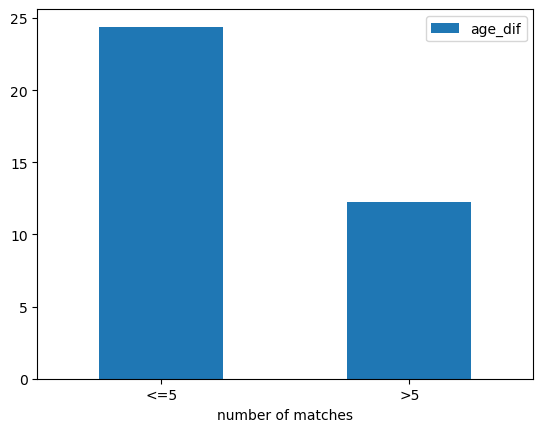

In [74]:
bar_graph = pd.DataFrame({'number of matches':['<=5', '>5'], 'age_dif':[df_copy[df_copy.number <=5]['age_dif'].max(),df_copy[df_copy.number > 5]['age_dif'].max()]})
ax = bar_graph.plot.bar(x='number of matches', y='age_dif', rot=0)